In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [5]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [6]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [7]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_neutral.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_neutral.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [8]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1951s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5105 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5293 - loss: 0.6922
Epoch 2: val_accuracy did not improve from 0.50000
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5294 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6896 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6168 - loss: 0.6873
Epoch 3: val_accuracy improved from 0.50000 to 0.72425, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6169 - loss: 0.6873 - val_accuracy: 0.7243 - val_loss: 0.6738 - learning_rate: 1.0000e-04
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6755 - loss: 0.6656
Epoch 4: val_accuracy did not improve from 0.72425
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6756 - loss: 0.6656 - val_accuracy: 0.6332 - val_loss: 0.6168 - learning_rate: 1.0000e-04
Epoch 5/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7746 - loss: 0.5834
Epoch 5: val_accuracy improved from 0.72425 to 0.78750, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7747 - loss: 0.5831 - val_accuracy: 0.7875 - val_loss: 0.4714 - learning_rate: 1.0000e-04
Epoch 6/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8533 - loss: 0.4280
Epoch 6: val_accuracy improved from 0.78750 to 0.88050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8534 - loss: 0.4278 - val_accuracy: 0.8805 - val_loss: 0.3250 - learning_rate: 1.0000e-04
Epoch 7/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8681 - loss: 0.3405
Epoch 7: val_accuracy did not improve from 0.88050
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8681 - loss: 0.3404 - val_accuracy: 0.8788 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8772 - loss: 0.3083
Epoch 8: val_accuracy improved from 0.88050 to 0.90100, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8773 - loss: 0.3083 - val_accuracy: 0.9010 - val_loss: 0.2553 - learning_rate: 1.0000e-04
Epoch 9/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8788 - loss: 0.2885
Epoch 9: val_accuracy improved from 0.90100 to 0.90150, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8788 - loss: 0.2885 - val_accuracy: 0.9015 - val_loss: 0.2503 - learning_rate: 1.0000e-04
Epoch 10/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8868 - loss: 0.2796
Epoch 10: val_accuracy improved from 0.90150 to 0.90400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8867 - loss: 0.2796 - val_accuracy: 0.9040 - val_loss: 0.2476 - learning_rate: 1.0000e-04
Epoch 11/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8803 - loss: 0.2869
Epoch 11: val_accuracy did not improve from 0.90400
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8803 - loss: 0.2869 - val_accuracy: 0.8957 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 12/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8827 - loss: 0.2815
Epoch 12: val_accuracy did not improve from 0.90400
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8827 - loss: 0.2815 - val_accuracy: 0.8957 - val_loss: 0.2534 - learning_rate: 1.0000e-04
Epoch 13/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8797 - loss: 0.2866
Epoch 13: val_accuracy did not improve from 0.90400
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8797 - loss: 0.2866 - val_accuracy: 0.8957 - val_loss: 0.2533 - learning_rate: 1.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8839 - loss: 0.2795 - val_accuracy: 0.9047 - val_loss: 0.2482 - learning_rate: 5.0000e-05
Epoch 16/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8894 - loss: 0.2781
Epoch 16: val_accuracy improved from 0.90475 to 0.90775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8894 - loss: 0.2780 - val_accuracy: 0.9078 - val_loss: 0.2392 - learning_rate: 5.0000e-05
Epoch 17/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8981 - loss: 0.2553
Epoch 17: val_accuracy improved from 0.90775 to 0.90875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8980 - loss: 0.2553 - val_accuracy: 0.9087 - val_loss: 0.2384 - learning_rate: 5.0000e-05
Epoch 18/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8865 - loss: 0.2754
Epoch 18: val_accuracy did not improve from 0.90875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8865 - loss: 0.2753 - val_accuracy: 0.9075 - val_loss: 0.2372 - learning_rate: 5.0000e-05
Epoch 19/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8892 - loss: 0.2610
Epoch 19: val_accuracy did not improve from 0.90875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8892 - loss: 0.2611 - val_accuracy: 0.9053 - val_loss: 0.2395 - learning_rate: 5.0000e-05
Epoch 20/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8938 - loss: 0.2665
Epoch 20: val_accuracy did not improve from 0.90875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8938 - loss: 0.2665 - val_accuracy: 0.9045 - val_loss: 0.2374 - learning_rate: 5.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8890 - loss: 0.2660 - val_accuracy: 0.9100 - val_loss: 0.2364 - learning_rate: 5.0000e-05
Epoch 22/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8854 - loss: 0.2786
Epoch 22: val_accuracy did not improve from 0.91000
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8854 - loss: 0.2786 - val_accuracy: 0.9087 - val_loss: 0.2352 - learning_rate: 5.0000e-05
Epoch 23/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8836 - loss: 0.2823
Epoch 23: val_accuracy did not improve from 0.91000
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8837 - loss: 0.2822 - val_accuracy: 0.9043 - val_loss: 0.2473 - learning_rate: 5.0000e-05
Epoch 24/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8930 - loss: 0.2604
Epoch 24: val_accuracy did not improve from 0.91000
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8930 - loss: 0.2604 - val_accuracy: 0.9087 - val_loss: 0.2338 - learning_rate: 5.00

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8973 - loss: 0.2547 - val_accuracy: 0.9115 - val_loss: 0.2308 - learning_rate: 2.5000e-05
Epoch 33/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8973 - loss: 0.2553
Epoch 33: val_accuracy did not improve from 0.91150
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8973 - loss: 0.2553 - val_accuracy: 0.9070 - val_loss: 0.2310 - learning_rate: 2.5000e-05
Epoch 34/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8927 - loss: 0.2577
Epoch 34: val_accuracy did not improve from 0.91150
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8927 - loss: 0.2577 - val_accuracy: 0.9107 - val_loss: 0.2294 - learning_rate: 2.5000e-05
Epoch 35/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8950 - loss: 0.2562
Epoch 35: val_accuracy improved from 0.91150 to 0.91250, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8950 - loss: 0.2562 - val_accuracy: 0.9125 - val_loss: 0.2291 - learning_rate: 2.5000e-05
Epoch 36/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8887 - loss: 0.2675
Epoch 36: val_accuracy did not improve from 0.91250
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8888 - loss: 0.2674 - val_accuracy: 0.9115 - val_loss: 0.2291 - learning_rate: 2.5000e-05
Epoch 37/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8973 - loss: 0.2580
Epoch 37: val_accuracy did not improve from 0.91250
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8973 - loss: 0.2580 - val_accuracy: 0.9105 - val_loss: 0.2286 - learning_rate: 2.5000e-05
Epoch 38/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8950 - loss: 0.2612
Epoch 38: val_accuracy did not improve from 0.91250
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8950 - loss: 0.2612 - val_accuracy: 0.9107 - val_loss: 0.2292 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9001 - loss: 0.2514 - val_accuracy: 0.9130 - val_loss: 0.2291 - learning_rate: 2.5000e-05
Epoch 40/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9024 - loss: 0.2457
Epoch 40: val_accuracy did not improve from 0.91300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9023 - loss: 0.2457 - val_accuracy: 0.9075 - val_loss: 0.2316 - learning_rate: 2.5000e-05
Epoch 41/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8964 - loss: 0.2626
Epoch 41: val_accuracy did not improve from 0.91300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8964 - loss: 0.2626 - val_accuracy: 0.9122 - val_loss: 0.2275 - learning_rate: 2.5000e-05
Epoch 42/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8942 - loss: 0.2637
Epoch 42: val_accuracy did not improve from 0.91300
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8942 - loss: 0.2636 - val_accuracy: 0.9115 - val_loss: 0.2269 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8966 - loss: 0.2564 - val_accuracy: 0.9137 - val_loss: 0.2254 - learning_rate: 2.5000e-05
Epoch 48/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8985 - loss: 0.2510
Epoch 48: val_accuracy did not improve from 0.91375
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8985 - loss: 0.2510 - val_accuracy: 0.9137 - val_loss: 0.2250 - learning_rate: 2.5000e-05
Epoch 49/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8929 - loss: 0.2612
Epoch 49: val_accuracy did not improve from 0.91375
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8929 - loss: 0.2612 - val_accuracy: 0.9130 - val_loss: 0.2247 - learning_rate: 2.5000e-05
Epoch 50/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9006 - loss: 0.2441
Epoch 50: val_accuracy improved from 0.91375 to 0.91400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9005 - loss: 0.2441 - val_accuracy: 0.9140 - val_loss: 0.2244 - learning_rate: 2.5000e-05
Epoch 51/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9038 - loss: 0.2486
Epoch 51: val_accuracy improved from 0.91400 to 0.91475, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9038 - loss: 0.2486 - val_accuracy: 0.9147 - val_loss: 0.2244 - learning_rate: 2.5000e-05
Epoch 52/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8952 - loss: 0.2509
Epoch 52: val_accuracy did not improve from 0.91475
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8952 - loss: 0.2509 - val_accuracy: 0.9122 - val_loss: 0.2245 - learning_rate: 2.5000e-05
Epoch 53/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8914 - loss: 0.2686
Epoch 53: val_accuracy did not improve from 0.91475
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8914 - loss: 0.2685 - val_accuracy: 0.9118 - val_loss: 0.2255 - learning_rate: 2.5000e-05
Epoch 54/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8989 - loss: 0.2519
Epoch 54: val_accuracy did not improve from 0.91475
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8989 - loss: 0.2520 - val_accuracy: 0.9125 - val_loss: 0.2241 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8895 - loss: 0.2599 - val_accuracy: 0.9150 - val_loss: 0.2224 - learning_rate: 2.5000e-05
Epoch 58/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8923 - loss: 0.2643
Epoch 58: val_accuracy improved from 0.91500 to 0.91525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8923 - loss: 0.2642 - val_accuracy: 0.9153 - val_loss: 0.2224 - learning_rate: 2.5000e-05
Epoch 59/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9008 - loss: 0.2511
Epoch 59: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9008 - loss: 0.2511 - val_accuracy: 0.9147 - val_loss: 0.2220 - learning_rate: 2.5000e-05
Epoch 60/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8987 - loss: 0.2502
Epoch 60: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8987 - loss: 0.2502 - val_accuracy: 0.9143 - val_loss: 0.2217 - learning_rate: 2.5000e-05
Epoch 61/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8975 - loss: 0.2546
Epoch 61: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8975 - loss: 0.2546 - val_accuracy: 0.9097 - val_loss: 0.2266 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9064 - loss: 0.2455 - val_accuracy: 0.9162 - val_loss: 0.2202 - learning_rate: 2.5000e-05
Epoch 65/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8965 - loss: 0.2597
Epoch 65: val_accuracy did not improve from 0.91625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8965 - loss: 0.2596 - val_accuracy: 0.9150 - val_loss: 0.2200 - learning_rate: 2.5000e-05
Epoch 66/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9009 - loss: 0.2474
Epoch 66: val_accuracy did not improve from 0.91625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9009 - loss: 0.2474 - val_accuracy: 0.9150 - val_loss: 0.2197 - learning_rate: 2.5000e-05
Epoch 67/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8966 - loss: 0.2540
Epoch 67: val_accuracy did not improve from 0.91625
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8966 - loss: 0.2539 - val_accuracy: 0.9112 - val_loss: 0.2225 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9003 - loss: 0.2532 - val_accuracy: 0.9165 - val_loss: 0.2193 - learning_rate: 2.5000e-05
Epoch 69/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8996 - loss: 0.2482
Epoch 69: val_accuracy did not improve from 0.91650
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8996 - loss: 0.2482 - val_accuracy: 0.9155 - val_loss: 0.2191 - learning_rate: 2.5000e-05
Epoch 70/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8970 - loss: 0.2534
Epoch 70: val_accuracy improved from 0.91650 to 0.91800, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8970 - loss: 0.2534 - val_accuracy: 0.9180 - val_loss: 0.2188 - learning_rate: 2.5000e-05
Epoch 71/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9007 - loss: 0.2514
Epoch 71: val_accuracy did not improve from 0.91800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9007 - loss: 0.2514 - val_accuracy: 0.9155 - val_loss: 0.2196 - learning_rate: 2.5000e-05
Epoch 72/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8999 - loss: 0.2548
Epoch 72: val_accuracy did not improve from 0.91800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8999 - loss: 0.2547 - val_accuracy: 0.9165 - val_loss: 0.2189 - learning_rate: 2.5000e-05
Epoch 73/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8955 - loss: 0.2612
Epoch 73: val_accuracy did not improve from 0.91800
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8955 - loss: 0.2611 - val_accuracy: 0.9162 - val_loss: 0.2176 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9013 - loss: 0.2501 - val_accuracy: 0.9185 - val_loss: 0.2162 - learning_rate: 2.5000e-05
Epoch 80/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8987 - loss: 0.2515
Epoch 80: val_accuracy did not improve from 0.91850
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8987 - loss: 0.2515 - val_accuracy: 0.9140 - val_loss: 0.2182 - learning_rate: 2.5000e-05
Epoch 81/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8993 - loss: 0.2538
Epoch 81: val_accuracy did not improve from 0.91850
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8993 - loss: 0.2537 - val_accuracy: 0.9172 - val_loss: 0.2154 - learning_rate: 2.5000e-05
Epoch 82/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8995 - loss: 0.2497
Epoch 82: val_accuracy improved from 0.91850 to 0.91875, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8995 - loss: 0.2496 - val_accuracy: 0.9187 - val_loss: 0.2149 - learning_rate: 2.5000e-05
Epoch 83/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9054 - loss: 0.2477
Epoch 83: val_accuracy did not improve from 0.91875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9054 - loss: 0.2477 - val_accuracy: 0.9170 - val_loss: 0.2145 - learning_rate: 2.5000e-05
Epoch 84/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8991 - loss: 0.2556
Epoch 84: val_accuracy did not improve from 0.91875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8991 - loss: 0.2556 - val_accuracy: 0.9170 - val_loss: 0.2143 - learning_rate: 2.5000e-05
Epoch 85/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9032 - loss: 0.2433
Epoch 85: val_accuracy did not improve from 0.91875
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9032 - loss: 0.2433 - val_accuracy: 0.9135 - val_loss: 0.2185 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8979 - loss: 0.2491 - val_accuracy: 0.9195 - val_loss: 0.2126 - learning_rate: 2.5000e-05
Epoch 91/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9032 - loss: 0.2407
Epoch 91: val_accuracy did not improve from 0.91950
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9032 - loss: 0.2407 - val_accuracy: 0.9193 - val_loss: 0.2122 - learning_rate: 2.5000e-05
Epoch 92/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9031 - loss: 0.2515
Epoch 92: val_accuracy did not improve from 0.91950
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9032 - loss: 0.2514 - val_accuracy: 0.9190 - val_loss: 0.2123 - learning_rate: 2.5000e-05
Epoch 93/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9020 - loss: 0.2505
Epoch 93: val_accuracy did not improve from 0.91950
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9020 - loss: 0.2505 - val_accuracy: 0.9195 - val_loss: 0.2117 - learning_rate: 2.50

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9003 - loss: 0.2503 - val_accuracy: 0.9200 - val_loss: 0.2113 - learning_rate: 2.5000e-05
Epoch 97/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9048 - loss: 0.2414
Epoch 97: val_accuracy did not improve from 0.92000
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9048 - loss: 0.2414 - val_accuracy: 0.9190 - val_loss: 0.2104 - learning_rate: 2.5000e-05
Epoch 98/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8990 - loss: 0.2407
Epoch 98: val_accuracy improved from 0.92000 to 0.92025, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8990 - loss: 0.2407 - val_accuracy: 0.9202 - val_loss: 0.2102 - learning_rate: 2.5000e-05
Epoch 99/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9001 - loss: 0.2476
Epoch 99: val_accuracy did not improve from 0.92025
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9001 - loss: 0.2475 - val_accuracy: 0.9107 - val_loss: 0.2206 - learning_rate: 2.5000e-05
Epoch 100/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8964 - loss: 0.2491
Epoch 100: val_accuracy did not improve from 0.92025
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8964 - loss: 0.2491 - val_accuracy: 0.9195 - val_loss: 0.2097 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 100.
Training completed.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


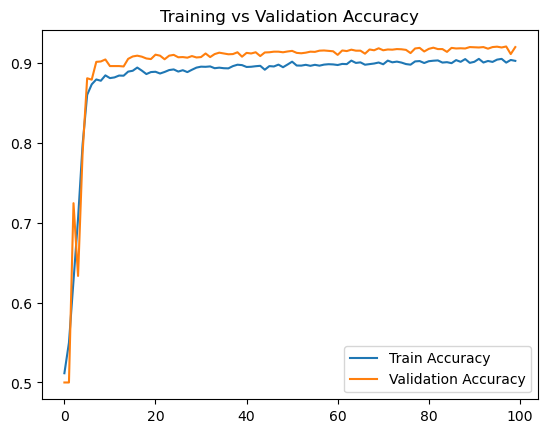

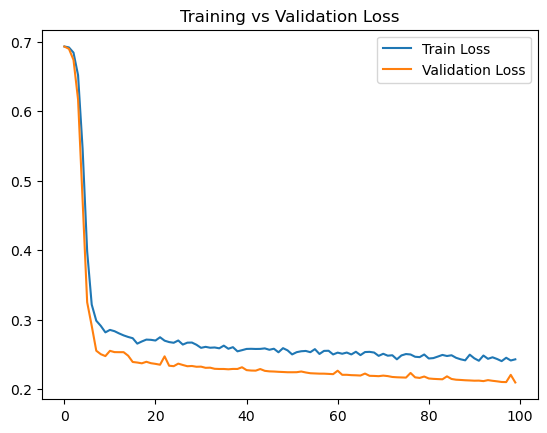

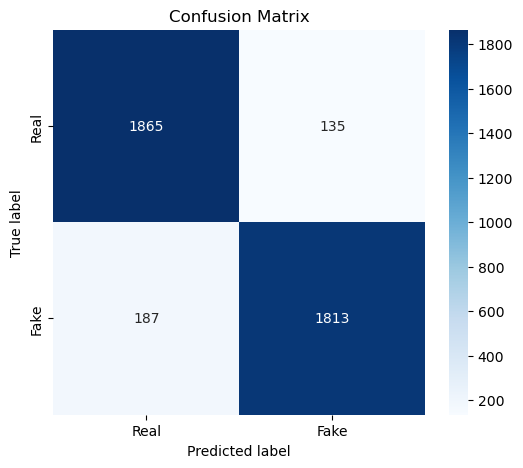

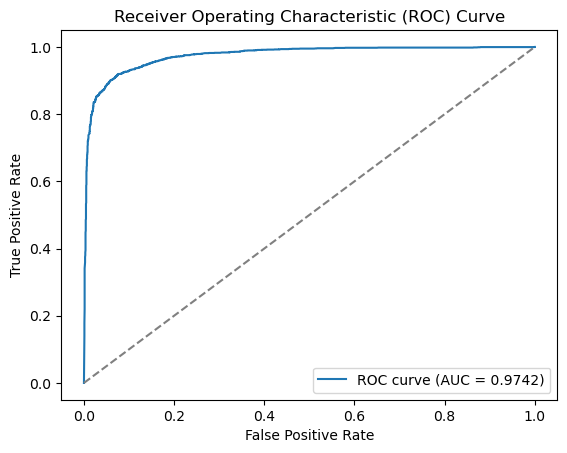

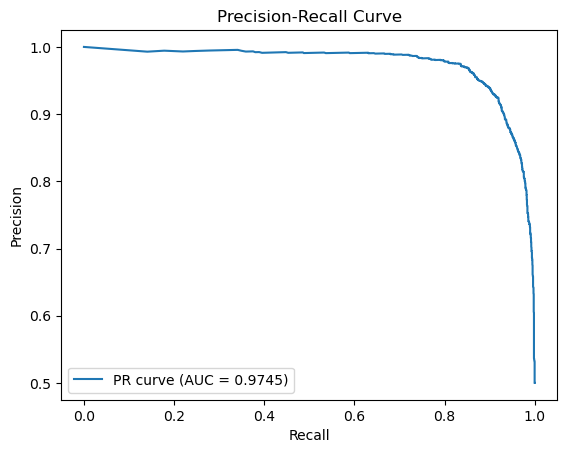

Accuracy Score: 0.9195
ROC AUC Score: 0.9742
Recall Score: 0.9065
Precision Score: 0.9307
F1 Score: 0.9184
PR AUC Score: 0.9745
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2000
           1       0.93      0.91      0.92      2000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



In [9]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)